In [115]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import numpy
import scipy
import random
import matplotlib as mpl
import pylab as plt
import time
import numba
#
import multiprocessing as mpp
import multiprocess as mp
#
import calc_pi as cp
import calc_mandelbrot as cmb
#

# Python: (some) best practices, optimizations, and parallelization

# Calculate Pi

Here, we demonstrate an area based, Reno-Nevada (poor person's Monte Carlo) method to estimate $pi$. We draw random numbers over a square with sides $L = 2R = 2$ and count the fraction of points that fall inside an enclosed circle with radius $R$. Eventually we will add a figure.

The gist of the formula is,

$\frac{N_{captured}}{N_{total}} = \frac {\pi R^2}{(2R)^2}$


Use this little PI calculator to illustrate methods of optimnization and parallelization. These will include:

1. Loop-loop (nested loop), which is a trainwreck for Python...
2. @numba.jit the loop-loop
3. Vectorize the random numbers
4. Parallelize various ways.
  1. Process() ?
  2. multiprocessing.Pool().map() ( and variants)
  3. mpi4py ?
  4. Embarrasingly parallel approach?



### First draft implementation
- Start with the simplest implementation
- NOTE: this is generally speaking a pretty terrible way to use Python
- But it illustrates all the main things.
- We will discuss how to improve it later.

In [14]:

# The base function:
def calc_pi_nogil(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

In [15]:
# This is the simplest, most straight forward=
#
t1 = time.time()
PIs = []
for N_max in numpy.arange(1E3, 1E5, 1E4):
    #print(f'*** Computing Pi for {N_max}')
    PIs += [[N_max, calc_pi_nogil(int(N_max))]]
dt_ll = time.time()-t1
print(f'** dt: {dt_ll}')
#
print('** Pi vals: ')
for n,pi in PIs:
    print(f'{n} :: {pi}')
#


** dt: 0.3353710174560547
** Pi vals: 
1000.0 :: 3.12
11000.0 :: 3.14
21000.0 :: 3.1156190476190475
31000.0 :: 3.1388387096774193
41000.0 :: 3.1341463414634148
51000.0 :: 3.1414901960784314
61000.0 :: 3.1419016393442623
71000.0 :: 3.1420845070422536
81000.0 :: 3.141185185185185
91000.0 :: 3.1454945054945056


## Some optimizations


## List comprehensions

A list comprehension is a more compact, some will say more intuitive and readable (others will disagree with one or more of those characteriztions) way to construct a list in Python. List comprehensions are usually faster than aggregating,  or even creating a list to size and assiging values (ie, PIs=list(NN_max) vs PIs=[]), albeit not always significantly.

In [16]:
# List comprehension way (a little bit faster...)
# this:
# X = []
# for k in range(n):
#     X+=[f(k)]
# becomes:
# X = [f(k) for k in range(n)]
#
t1 = time.time()
PIs = [[N_max, calc_pi_nogil(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
print(f'** dt: {time.time()-t1}')
#
print('** Pi vals: ')
for n,pi in PIs:
    print(f'{n} :: {pi}')
#


** dt: 0.3392479419708252
** Pi vals: 
1000.0 :: 3.24
11000.0 :: 3.1538181818181816
21000.0 :: 3.1363809523809523
31000.0 :: 3.1486451612903226
41000.0 :: 3.1366829268292684
51000.0 :: 3.1430588235294117
61000.0 :: 3.140065573770492
71000.0 :: 3.1547605633802815
81000.0 :: 3.141925925925926
91000.0 :: 3.134813186813187


## Vectorization
- Probably first, most reliable and stable optimization
- Pass a sequence (vector) of values to the processor, rather than one variable at a time
- Makes _MUCH_ better use of the processers cache(s)
- Often simplified syntax _AND_ much improved performance.

Let's rewrite calc_pi(), a little more creatively.


In [18]:
def calc_pi_vec(N):
    #M = 0
    # spell it out, then consolidate...
    #X = numpy.random.random(N)
    #Y = numpy.random.random(N)
    #Z = X**2 + Y**2
    #
    # All of that in one line...
    # You should experiment with some of this syntax to evaluate performance.
    # this looks much faster than numpy.square()
#    Z = numpy.sum( numpy.random.random( (2,N) )**2. , axis=0 )
#    #Z = numpy.sum( numpy.square( numpy.random.random( (2,N) ) ), axis=0 )
#    #
#    # as a little trick, sum the index of (Z<1)
#    M = numpy.sum((Z<1))
    
    M = numpy.sum( (numpy.sum( numpy.random.random( (2,N) )**2. , axis=0 ))<1 )
    #
    return 4.0*M/N


## numba
- Use `@jit` to pre-compile the function.
- This often works _REALLY_ well for simple, just-math functions. Numpy containers, internal functions, etc. have potential to confuse `numba`
- So numba is often a way to make a really bad code (eg, a loop-loop), really good, but it can be complicated to make a pretty-good code much better.
- `numba` also has some compile-time options, which we will show below. These include:
  - Releasing the `GIL`
  - (almost!) Automagical parallelization (much like `parfor`)
- `numba` can be annoying to work with. There are cases where it will generate loads of warning messages, which are difficult to suppress.
- You have to be realy careful to keep your parallel codes thread-safe


In [108]:
## Compile with Numba:
#
@numba.jit()
def calc_pi_1(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True)
def calc_pi_2(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True, nogil=True)
def calc_pi_3(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N
#
# How 'bout this?
@numba.njit(parallel=True)
def calc_pi_njp(N):
    M = 0
    for i in numba.prange(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

## Benchmark
- Compare performance for loop-loop, vectorization, and versions of `numba.jit`
- Note that `numba.jit` performs much better for this example. 
- There are likely some subtlties in the vectorization that can be resolved, but...
- Mostly, this is because our kernel functions are just pure Python math, which are put through a simple loop If there were other libries included in those functions, eg. `random.random()` let alone anything `numpy`, `numba` would likely throw a bunch of warnings and the acceleration would be reduced.

### Comments on benchmarking:
- Straight forward, but can be tricky! Some things to look out for...
- SW or HW solutions that "help" by cacheing results (maybe chanbe up the problem a little bit?)
- For `numba` (and other optimizers), run a small job first, to be sure the code compiles
- Is there some other overhead affecting your benchmark?
- `%timeit` is pretty awesome, but beware artifacts from overhead...
- Is your computer doing other things too?
- Understand the problem and the code and stategize accordingly. Eg, is `range(10E7)` equivalent (better?) than `[f(10E7) for k in range(10)]`


In [91]:
# try the different jit-compile options:
#
N_max=1E7
for f in (cp.calc_pi_loop_loop, cp.calc_pi_vec, cp.calc_pi_jit,\
          cp.calc_pi_jit_np, cp.calc_pi_jit_ng, cp.calc_pi_jit_ng_np,\
         calc_pi_njp):
    # 
    # do a quick run, so we dont' count compile time.
    dummy_var = f(500)
    t1 = time.time()
    #PIs = [[N_max, f(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
    pi = f(int(N_max + random.randint(1,10)))
    print(f'f = {f.__name__}')
    print(f'** dt: {time.time()-t1}')
    print(f'** pi: {pi}\n')
    #
#     print('** Pi vals: ')
#     for n,pi in PIs:
#         print(f'{n} :: {pi}')

f = calc_pi_loop_loop
** dt: 7.562118053436279
** pi: 3.1413434869252104

f = calc_pi_vec
** dt: 0.333071231842041
** pi: 3.1424760287619855

f = calc_pi_jit
** dt: 0.11127710342407227
** pi: 3.141971543211383

f = calc_pi_jit_np
** dt: 0.11020994186401367
** pi: 3.141710829144585

f = calc_pi_jit_ng
** dt: 0.11571097373962402
** pi: 3.1420836579163423

f = calc_pi_jit_ng_np
** dt: 0.11632013320922852
** pi: 3.141117972993824

f = calc_pi_njp
** dt: 0.031295061111450195
** pi: 3.142179886256091



## `numba` parallel
- Note the `numba.njit(parallel=True)` compilation/decoration example above.
- For simple loops, this may be about as good as it gets
- But as discussed, its applicaiton may be limited, and you have to be careful.


## Embarrasingly parallel
- Kind of a dumb example, unless we make the problem much bigger. Maybe Mandelbrot?
- Alas... The idea is to run many independent instances, then separately collect and aggregate.
- Consider a wrapper functoin:
```
    def calc_pi_n_write(f_pi=calc_pi_jit_np, Nits=int(1E7), fout_name=None):
    '''
    # comput pi and output to fout. We will use this as a simple demonstrator of emb. parallal.
    '''
    pi = f_pi(Nits)
    #
    if not fout_name is None:
        with open(fout_name, 'a') as fout:
            fout.write(f'pi:{pi}\n')
    return pi
```
- Which we can submit to the scheduler with something like this:
```
    #!/bin/bash
    #
    #SBATCH --job-name=e-p_compute_pi
    #SBATCH --output=comp_pi.out
    #SBATCH --error=comp_pi.err
    #SBATCH --mem-per-cpu=1g
    #SBATCH --cpus-per-task=1
    #SBATCH --ntasks=1
    #SBATCH --partition=serc,normal,owners
    #SBATCH --time=00:10:00
    #
    module purge
    #module load python/3.9
    #module load py-sherlock/
    module load anaconda/3.11
    #
    PI_OUTPUT=ep_pi.csv
    #
    python3 -c "import calc_pi as cp;cp.calc_pi_n_write(fout_name='${PI_OUTPUT}')"
```
- We can submit/run multiple instances by either:
  - Submitting a whole bunch of individual jobs: This is sloppy, hard on the scheduler, and will make Kilian angry.
  - Job array (eg, `--array=0-100%10`): This is usually optimal. We can submit LOTS of instances, but still control concurrent resource use with the `%` operator.
    - `sbatch --array=0-16 e_paralell_pi.sh `
  - `--ntasks`: This is not really what `--ntasks` was meant to do, but it will work. In this case, it will launch `--ntasks` instances, simultaneously and running in parallel.
    - `sbatch --ntasks=16 e_paralell_pi.sh `
 
 

## Parallel compute: Multiprocessing
Parallel computation in Python is fundamentally limited by the Global Interpreter Lock (GIL), which basically limits Python to do one thing at a time. You can, for example, launch tasks as threads -- which in other envoronments might be allowed to run in parallel, but in Python, those threads run sequentially.

There are two basic approaches to working around the GIL:
1. Use (compiled) components that operate in parallel -- but appear effectively serial to Python
2. Launch multiple instances of Python

There are numerous examples of the first case. We have already seen that `numba` can do this. we also see this in many compilations of `numpy` matrix algebra. The built in Python module `multiprocessing` takes the second approach. Though it is limited to a single machine, `multiprocessing` in some ways resembles an MPI framework -- a comput job is broken up into pieces, then "pickled" (serialized) and run as independent processes; the GIL is maintained in each separeat thread.

The main disadvantages of `multiprocessing` is that there is relatively high compute and memory overhead -- since the entire process has to be copied, and it can be programmatically complicated (nominally, simpler than most MPI programs, but more difficult than `parfor`). Another disadvantage is that -- as mentioned, it is limited to a single machine.

On that latter note, consider the cousin library, `multiprocess` -- more or less a copy of `multiprocessing` that includes several multi-node options -- eg, an MPI capagle `Pool()` class. Note that multiprocessing, and especially MPI, or other multi-node capable options, appear to be a very active work in progress at this time (Oct 2023), so there might be other good options available (see for example `pip install mpipool`... I think).

For now we focus on `multiprocessing`. Some of the salient components include:

- Process(): The simplest example, nominally applies well to this example
- Pool(): Sort of a dumb way to use a Pool(), but we're in the business of making examples
- Queue(): I've never used a queueu, but...

**NOTE:** Multiprocessing will _not_ work in notebooks. Parallelized functions must be off-loaded to a .py module, so that the function can be properly referenced and copied when it is serialized.


## MPP structural elements
- Pipe()
- Process()
- Pool()
- Other things too...
- (NOTE: these codes are reproduced in an external module so they can be run in parallel).

In [97]:
# MPP Process()
#. it is possible that the syntax for this has changed, which is to say that this attempt and even the 
#. line-for-line example from the docs does not appear to run. 
# Note that these codes will not run in parallel, but their off-notebook counterparts will.
#
# Sometimes, there are lots of wrapper functions in parallel Python programming.

# try this:
def calc_pi_pipe(N, conn):
    '''
    # A simple demonstration of how to use Pipe() comm pairs. Basically replace or agment return x
    # with conn.send(x)
    '''
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    #return 4 * M / N
    conn.send([N, 4*M/N])
    conn.close()

def pipe_wrapper(f, n_max, conn):
    '''
    # If you have a workiong function f , you might run it with a process (or do something else)
    # by wrapping it in a function like this. Note that this looks super generalized, but it actually
    # has a very specific call signature.
    # more versatile wrappers use the *args, **kwargs inputs, but this can create its own issues, so...
    '''
    pi = f(n_max)
    #print('*** ', pi)
    conn.send([n_max, pi])
    conn.close()
    #
    #return None
    

#def f_process(f=None, n_processes=1, N_max=1000, *args):
def f_process(f=None, n_processes=1, N_max=1000):
    '''
    # A quick-n-dirty way to wrap a function f so we can run it as a Process()
    '''
    # This is a sort of stupid way to write this function, but it gets the job done.
    # production applications will probably be either much better generalized or much more specific.
    #
    #args = [f, N_max] + list(args)
    #
    pipes = [mpp.Pipe() for k in range(n_processes)]
    Ps = [mpp.Process(target=pipe_wrapper, args=tuple([f, N_max, p2])) for p1,p2 in pipes]
    #Ps = [mpp.Process(target=calc_pi_pipe, args=tuple([N_max, p2])) for p1,p2 in pipes]
    #
    for (p1, p2), p in zip(pipes, Ps):
        print("*** Starting process...", p, p1, p2)
        # NOTE: this will not do anything if f (or the rest of this???) is in a notebook.
        #p.start()
        #p.join()
        # this will work in a notebook, but will run serially.
        p.run()
        #p1.recv()
        

        
#    for p in Ps:
#        p.join()
#     print('*** jobs started, now recv()')
#     for p in Ps:
#         p.close()
#     pis = [p1.recv() for p1, p2 in pipes]
    #
    pis = [p1.recv() for p1, p2 in pipes]
    #
    # Ugh...
    # TODO: 
    #. to get results from this, each process either needs to point somewhere for an output,
    #. you can pass a queue a parameter to collect output, our you have to set up Pipe() objects.
    #Results = [p.get() for p in Ps]
    #
    #return Results
    
    return pis
    
    

### Examples of using Process(), Pipe(), etc.
- These do not actually parallelize...
- But we illustrate how to use some of these classes and functions.


In [ ]:
#pi = f_process(calc_pi_nogil, 4, N_max=10000)
pi = f_process(calc_pi_vec, 4, N_max=10000)
#

p1, p2 = mpp.Pipe()
print('** ', pipe_wrapper(calc_pi_vec, int(1E7), p2))
print('** **: ', p1.recv())

p1,p2 = mpp.Pipe()
print('** ', calc_pi_pipe(int(1E7), p2))
#print('** ', pipe_wrapper(calc_pi_vec, 500, p2))
print('** **: ', p1.recv())


### Example: Use a generalized wrapper function to run one of several pi calculations in a Process()
- Note the use of: *args, **kwargs

In [112]:
# Another example of a simple wrapper script:
# run function f() in a Process(); pass *args and **kwargs; return output via a Pipe()
#
N_max = int(1E7)
def f_pipe(f, pipe, *args, **kwargs):
    x = f(*args, **kwargs)
    pipe.send(x)
    pipe.close()

for f in cp.calc_pi_loop_loop, cp.calc_pi_vec, calc_pi_njp, cp.calc_pi_njp:
    # create a comm/Pipe() pair:
    p1, p2 = mpp.Pipe()
    t1 = time.time()
    #P = mpp.Process(target=f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max)])
    P = mpp.Process(target=f_pipe, args=[f, p2, int(N_max + random.randint(1,100))])
    #
    # NOTE: in our notebook, we use P.run(), which is serial. For parallel function,
    #  we need to move the code to a .py module and use P.start()
    P.run()
    pi = p1.recv()

    P.close()
    p1.close()
    p2.close()
    #
    print(f'** f = {f}')
    print(f'*** pi={pi}, dt={time.time()-t1}\n' )
#

** f = <function calc_pi_loop_loop at 0x7fa3f1d89dc0>
*** pi=3.1421319203050615, dt=7.4106199741363525

** f = <function calc_pi_vec at 0x7fa3f2dc2dc0>
*** pi=3.1406428921356127, dt=0.30223894119262695

** f = CPUDispatcher(<function calc_pi_njp at 0x7fa3f3292c10>)
*** pi=3.141768205335794, dt=0.029903173446655273

** f = CPUDispatcher(<function calc_pi_njp at 0x7fa3efe559d0>)
*** pi=3.141025580769538, dt=0.028474807739257812



In [52]:
N=int(1E7)
print('*** ', cp.calc_pi_jit(N))
print('*** 4cpus', cp.pool_wrapper(f=cp.calc_pi_jit, ncpus=4, f_agg=numpy.mean, N=N))
print('*** 1cpu', cp.pool_wrapper(f=cp.calc_pi_jit, ncpus=1, N=N))
#
# now, try the recursive wrapper:
print('** using calc_pi() with the recursive bit')
for n in range(1,5):
    print(f'*** [{n}]: {cp.calc_pi(N, n)}')



***  3.141894
*** 4cpus [3.1413316]
*** 1cpu 3.1409176
** using calc_pi() with the recursive bit
*** [1]: 3.1422516
*** [2]: 3.1419764
*** [3]: 3.1409627140962715
*** [4]: 3.1417336000000002


In [ ]:
# Now, try with the nested recursive bit:
t1 = time.time()
pi_v = cp.calc_pi_vec(N_max*10)
print(f'vector ({pi_v}):: {time.time()-t1}')

t1 = time.time()
pi_vr = cp.calc_pi_vec_mpp(N_max*10, ncpus=4)
print(f'vector_mpp ({pi_vr}):: {time.time()-t1}')
#

In [70]:
# try the jit recursive bit and introduce timeit:
for n in range(1,5):
    #%timeit print(f'mpp[{n}]: {cp.calc_pi(1E6, n)}')
    %timeit print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(1E6/n))}')
#

pool[2]: 6.28344
pool[2]: 6.2815840000000005
pool[2]: 6.277407999999999
pool[2]: 6.283088
pool[2]: 6.290144
pool[2]: 6.2790479999999995
pool[2]: 6.282056
pool[2]: 6.282696
1.45 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[3]: 9.433653433653433
pool[3]: 9.41874941874942
pool[3]: 9.424245424245424
pool[3]: 9.429777429777431
pool[3]: 9.42063342063342
pool[3]: 9.427713427713428
pool[3]: 9.42942942942943
pool[3]: 9.423633423633424
1.74 s ± 212 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[4]: 12.556607999999999
pool[4]: 12.569152
pool[4]: 12.559328
pool[4]: 12.56368
pool[4]: 12.572464
pool[4]: 12.562032
pool[4]: 12.571424
pool[4]: 12.571488
1.77 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
# try the jit recursive bit and introduce timeit:
print(f'*** mpp.cpu_count(): {mpp.cpu_count()}')
NN = int(1E7)
for n in range(1,7):
    t0 = time.time()
    print(f'mpp[{n}]: {cp.calc_pi(NN, n)}')
    print(f'** time[{n}]: {time.time()-t0}')
    #
    t0 = time.time()
    print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(NN/n))}')
    print(f'** time[{n}]: {time.time()-t0}')
    print('\n')
#

*** mpp.cpu_count(): 8
mpp[1]: 3.1413636
** time[1]: 7.235046863555908
pool[1]: 3.1415188
** time[1]: 8.147811651229858


mpp[2]: 3.1406739999999997
** time[2]: 2.8564717769622803
pool[2]: 3.1426856
** time[2]: 4.979939937591553


mpp[3]: 3.1423607142360717
** time[3]: 4.27752423286438
pool[3]: 3.1405983140598313
** time[3]: 4.390532732009888


mpp[4]: 3.1418424
** time[4]: 5.45414400100708
pool[4]: 3.1426004
** time[4]: 3.8474230766296387


mpp[5]: 3.1414239999999998
** time[5]: 6.515172958374023
pool[5]: 3.1422803999999998
** time[5]: 4.948551177978516


mpp[6]: 3.141696056678423
** time[6]: 7.768233776092529
pool[6]: 3.1418792567517024
** time[6]: 4.1648828983306885




In [78]:
N_max = int(1E7)
f_pi = cp.calc_pi_loop_loop
#f_pi = cp.calc_pi_vec
t1 = time.time()
pi=f_pi(N_max)
print(f'*** pi={pi}, dt={time.time()-t1}' )
#
print('*** Single process, off-loaded:')
# Now, do a single off-loaded process, for demo purposes
p1, p2 = mpp.Pipe()
t1 = time.time()
P = mpp.Process(target=cp.f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max)])
#P.run()
#print("now start...")
P.start()
#print("now join...")
P.join()
pi2 = p1.recv()
#print(" should be receivec...")
#
P.close()
p1.close()
p2.close()

print(f'*** pi={pi2}, dt={time.time()-t1}' )
#
# now, add some more processes:
# NOTE: I think that, in order to start() a process, it must be defined in an external module,
# "accessible by __main__". It's not totally clear what the requirement is...
ncpus = 4
print(f'*** For multiple ({ncpus}) processes?')
t1=time.time()

pipes = [mpp.Pipe() for k in range(ncpus)]
Procs = [mpp.Process(target=cp.f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max/ncpus)]) for p1,p2 in pipes]
#
for k,P in enumerate(Procs):
    print(f'** start {k}')
    P.start()
    print('*** is_alive: ', P.is_alive())
    #P.join()
    #print('*** is_alive: ', P.is_alive())
    #P.run()
    #print('*** is_alive: ', P.is_alive())
for P in Procs:
    P.join()
    
pis = [p1.recv() for p1,p2 in pipes]
#
for (p1,p2),P in zip(pipes,Procs):
    p1.close()
    p2.close()
    P.close()

print(f'*** {pis}, {numpy.mean(pis)}, {time.time()-t1}')

*** pi=3.1420792, dt=7.182585716247559
*** Single process, off-loaded:
*** pi=3.141752, dt=8.994734764099121
*** For multiple (4) processes?
** start 0
*** is_alive:  True
** start 1
*** is_alive:  True
** start 2
*** is_alive:  True
** start 3
*** is_alive:  True
*** [3.1415904, 3.1430112, 3.1409552, 3.1414448], 3.1417504000000003, 3.9756860733032227


In [141]:
mb_set = cmb.mandelbrotter(d_im=.01, d_re=.01)

** DEBUG:  300 300


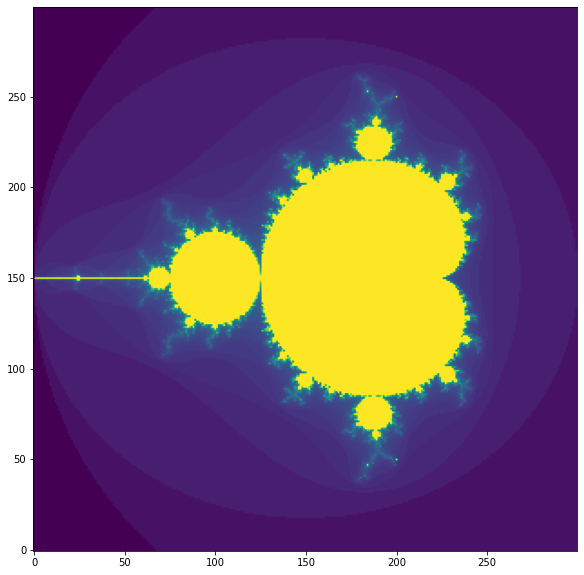

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax.imshow(mb_set['Ks']**(1/3), origin='lower')

#ax.set_xlabel("$\Re(c)$")
#ax.set_ylabel("$\Im(c)$")